# Dependências 

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
from glob import glob
from os.path import basename
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, LSTM, Dropout, Embedding
from keras.models import Sequential

pd.options.display.max_columns = None

Using TensorFlow backend.


In [2]:
COLS_SCOUTS_DEF = ['CA','CV','DD','DP','FC','GC','GS','RB','SG'] # alphabetical order
COLS_SCOUTS_ATK = ['A','FD','FF','FS','FT','G','I','PE','PP'] # alphabetical order
COLS_SCOUTS = COLS_SCOUTS_DEF + COLS_SCOUTS_ATK

COLS_STATISTICS = ['atletas.pontos_num', 'atletas.preco_num', 'atletas.variacao_num', 'atletas.media_num']
COLS_ATHLETES_INFO = ['atletas.atleta_id', 'atletas.apelido', 'atletas.posicao_id', 'atletas.clube.id.full.name', 'atletas.status_id']

COL_ID = 'atletas.atleta_id'
COL_ROUND = 'atletas.rodada_id'
COL_POINTS = 'atletas.pontos_num'
COL_POSITION = 'atletas.posicao_id'
COL_STATUS = 'atletas.status_id'
COL_TEAM_ID = 'atletas.clube.id.full.name'
COL_NICKNAME = 'atletas.apelido'

COLS_ALL = [COL_ROUND] + COLS_ATHLETES_INFO + COLS_STATISTICS + COLS_SCOUTS

# Análise dos Dados 

In [3]:
def import_data(folder_year):
    list_files = glob(folder_year + 'rodada-*.csv')
    df_data = pd.DataFrame([])
    
    for file in list_files:
        df_round = pd.read_csv(file, index_col=0)
        print('Importando {} linhas do arquivo {}'.format(df_round.shape[0], basename(file)))
        df_data = df_data.append(df_round, sort=False)
    return df_data

In [4]:
df = import_data('../../data/2019/')
df = df[COLS_ALL]
print(df.shape)

df.describe()

Importando 740 linhas do arquivo rodada-1.csv
Importando 738 linhas do arquivo rodada-2.csv
Importando 737 linhas do arquivo rodada-3.csv
(2215, 28)


,atletas.rodada_id,atletas.atleta_id,atletas.pontos_num,atletas.preco_num,atletas.variacao_num,atletas.media_num,CA,CV,DD,DP,FC,GC,GS,RB,SG,A,FD,FF,FS,FT,G,I,PE,PP
count,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.00000,196.000000,12.0,55.000000,5.0,631.000000,5.0,60.000000,621.000000,112.0,96.000000,280.000000,374.000000,616.000000,30.0,135.000000,102.000000,759.000000,5.0
mean,1.998646,83113.875395,1.132135,4.957201,0.000533,1.28865,1.102041,1.0,3.381818,1.0,2.434231,1.0,2.883333,2.636071,1.0,1.072917,1.400000,1.545455,2.295455,1.0,1.148148,1.137255,3.476943,1.0
std,0.816772,18840.884935,2.922716,3.647539,1.428009,2.73669,0.303477,0.0,2.422815,0.0,1.650887,0.0,1.391154,1.957513,0.0,0.298938,0.796948,0.894918,1.731688,0.0,0.396223,0.373350,2.473966,0.0
min,1.000000,36886.000000,-9.000000,0.690000,-9.310000,-9.00000,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0
25%,1.000000,71721.500000,0.000000,2.000000,0.000000,0.00000,1.000000,1.0,1.000000,1.0,1.000000,1.0,2.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,2.000000,1.0
50%,2.000000,86932.000000,0.000000,4.000000,0.000000,0.00000,1.000000,1.0,3.000000,1.0,2.000000,1.0,3.000000,2.000000,1.0,1.000000,1.000000,1.000000,2.000000,1.0,1.000000,1.000000,3.000000,1.0
75%,3.000000,98910.500000,0.800000,6.520000,0.000000,1.90000,1.000000,1.0,5.000000,1.0,3.000000,1.0,4.000000,3.000000,1.0,1.000000,2.000000,2.000000,3.000000,1.0,1.000000,1.000000,5.000000,1.0
max,3.000000,105585.000000,22.700000,22.740000,14.520000,22.70000,2.000000,1.0,9.000000,1.0,12.000000,1.0,7.000000,12.000000,1.0,3.000000,5.000000,5.000000,11.000000,1.0,3.000000,3.000000,16.000000,1.0


In [5]:
pandas_profiling.ProfileReport(df)

Number of variables,29
Number of observations,2215
Total Missing (%),55.7%
Total size in memory,501.9 KiB
Average record size in memory,232.0 B
Numeric,19
Categorical,4
Boolean,6
Date,0
Text (Unique),0
Rejected,0


In [6]:
print("Dimensões originais dos dados: ", df.shape)

# remove todas as linhas cujo scouts são NANs 
df_clean = df.dropna(how='all', subset=COLS_SCOUTS)
print('qtde. de jogadores com scouts: ', df_clean.shape[0])

# remove técnicos
df_clean = df_clean[df_clean[COL_POSITION] != "tec"]
print("qtde. de linhas com posições válidas: ", df_clean.shape[0])

# altera os Status == 'Nulo' para 'Provável'
df_clean.loc[df_clean[COL_STATUS] == 'Nulo', COL_STATUS] = 'Provável'

# preenche scouts NANs com zero
df_clean[COLS_SCOUTS] = df_clean[COLS_SCOUTS].fillna(value=0)

print("Dimensão dos dados após as limpezas: ", df_clean.shape)
df_clean.head(10)

# checa se ainda existem valores nulos
assert(~df_clean.isnull().any().any())

df_clean.describe()

Dimensões originais dos dados:  (2215, 28)
qtde. de jogadores com scouts:  933
qtde. de linhas com posições válidas:  933
Dimensão dos dados após as limpezas:  (933, 28)


,atletas.rodada_id,atletas.atleta_id,atletas.pontos_num,atletas.preco_num,atletas.variacao_num,atletas.media_num,CA,CV,DD,DP,FC,GC,GS,RB,SG,A,FD,FF,FS,FT,G,I,PE,PP
count,933.000000,933.000000,933.000000,933.00000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000
mean,2.120043,76717.426581,2.463773,6.77821,0.008553,2.834405,0.231511,0.012862,0.199357,0.005359,1.646302,0.005359,0.185423,1.754555,0.120043,0.110397,0.420150,0.619507,1.515541,0.032154,0.166131,0.124330,2.828510,0.005359
std,0.806728,19182.950826,4.031528,4.11696,2.169492,3.568779,0.470131,0.112738,0.987540,0.073048,1.772247,0.073048,0.789498,2.024208,0.325186,0.339826,0.776051,0.945922,1.778214,0.176504,0.431150,0.375736,2.610346,0.073048
min,1.000000,37604.000000,-9.000000,0.69000,-9.310000,-9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,68696.000000,0.000000,3.76000,-1.130000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2.000000,80275.000000,1.000000,5.76000,0.000000,2.100000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000
75%,3.000000,91772.000000,4.200000,8.94000,0.730000,4.770000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,4.000000,0.000000
max,3.000000,105553.000000,22.700000,22.74000,14.520000,22.700000,2.000000,1.000000,9.000000,1.000000,12.000000,1.000000,7.000000,12.000000,1.000000,3.000000,5.000000,5.000000,11.000000,1.000000,3.000000,3.000000,16.000000,1.000000


[1 2 3] [254 313 366]


<BarContainer object of 3 artists>

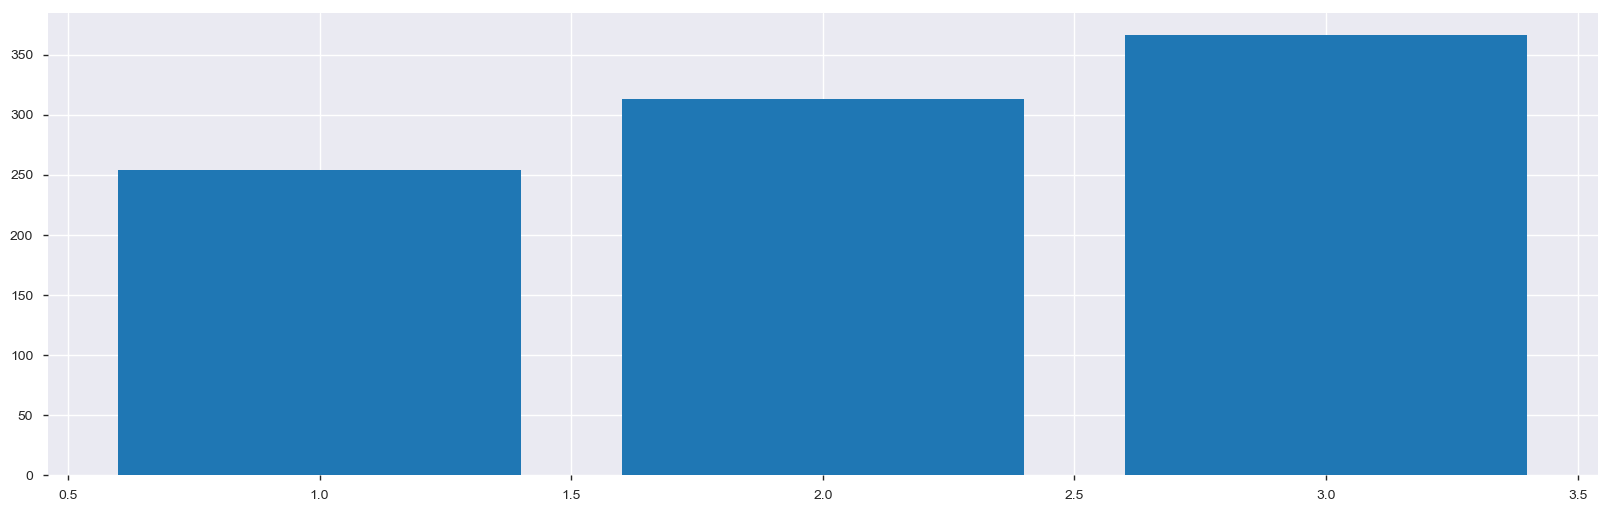

In [7]:
unique, counts = np.unique(df_clean[COL_ROUND].values, return_counts=True)
print(unique, counts)

plt.figure(figsize=(20, 6))
plt.bar(unique, counts)

# Criação das Amostras

In [8]:
def create_samples(df, cols_of_interest, from_round=1, to_round=None, last_rounds=None, return_pred=True):
    players = list(df[COL_ID].unique())
    rounds = list(df[COL_ROUND].unique())
    n_rounds = max(rounds)
    n_players = len(players)
    to_round = n_rounds if to_round is None else to_round
    last_rounds = n_rounds - 1 if last_rounds is None else last_rounds

    list_rounds = np.array([list(range(1, n_rounds+1))  for _ in range(n_players)]).flatten()
    list_players = np.array([[player] * n_rounds for player in players]).flatten()
    df_all = pd.DataFrame([[p, r] for p, r in zip(list_players, list_rounds)], columns=[COL_ID, COL_ROUND])

    df_merge = df_all.merge(df, how='left', on=[COL_ID, COL_ROUND])
    df_merge.fillna(value=0, inplace=True)
    
    x, y = [], []
    for r in range(from_round, to_round, last_rounds):
        print('x: rodadas de {:}-{:} y: rodada {}'.format(r, r + last_rounds - 1, r + last_rounds))
        
        df_round = df_merge[(df_merge[COL_ROUND] >= r) & (df_merge[COL_ROUND] < r + last_rounds)]
        df_group = df_round.groupby(by=[COL_ID], as_index=False, sort=False)
        x.append([data[cols_of_interest].values for _, data in df_group])
            
        df_ids = pd.DataFrame([data[COL_ID].values[0] for _, data in df_group], columns=[COL_ID])
        if return_pred:
            df_next = df_merge[df_merge[COL_ROUND] == r + last_rounds]
            assert(np.all(df_ids[COL_ID].values ==  df_next[COL_ID].values))

            df_points = df_ids.merge(df_next, how='left', on=[COL_ID])[COL_POINTS]
            y.append(df_points.fillna(value=0).values)
        
    return np.concatenate([r for r in x]), np.array(y).flatten() if return_pred else df_ids[COL_ID].values

In [9]:
df_samples = pd.get_dummies(df_clean, columns=[COL_POSITION, COL_TEAM_ID], prefix=['pos', 'clube'])
df_samples.head()

,atletas.rodada_id,atletas.atleta_id,atletas.apelido,atletas.status_id,atletas.pontos_num,atletas.preco_num,atletas.variacao_num,atletas.media_num,CA,CV,DD,DP,FC,GC,GS,RB,SG,A,FD,FF,FS,FT,G,I,PE,PP,pos_ata,pos_gol,pos_lat,pos_mei,pos_zag,clube_Athlético-PR,clube_Atlético-MG,clube_Avaí,clube_Bahia,clube_Botafogo,clube_CSA,clube_Ceará,clube_Chapecoense,clube_Corinthians,clube_Cruzeiro,clube_Flamengo,clube_Fluminense,clube_Fortaleza,clube_Goiás,clube_Grêmio,clube_Internacional,clube_Santos,clube_São Paulo,clube_Vasco
1,1,80196,Yago Pikachu,Provável,2.0,11.10,-2.90,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,1,78445,Renê,Provável,0.6,8.74,-3.26,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,1,80853,Pedro Geromel,Provável,8.0,12.49,2.49,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10,1,38229,Fábio Santos,Provável,9.4,12.77,3.77,9.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,38910,Ricardo Oliveira,Provável,12.3,18.94,3.94,12.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
cols_of_interest = df_samples.columns.drop([COL_ROUND, COL_ID, COL_NICKNAME, COL_STATUS])
cols_of_interest

Index(['atletas.pontos_num', 'atletas.preco_num', 'atletas.variacao_num',
       'atletas.media_num', 'CA', 'CV', 'DD', 'DP', 'FC', 'GC', 'GS', 'RB',
       'SG', 'A', 'FD', 'FF', 'FS', 'FT', 'G', 'I', 'PE', 'PP', 'pos_ata',
       'pos_gol', 'pos_lat', 'pos_mei', 'pos_zag', 'clube_Athlético-PR',
       'clube_Atlético-MG', 'clube_Avaí', 'clube_Bahia', 'clube_Botafogo',
       'clube_CSA', 'clube_Ceará', 'clube_Chapecoense', 'clube_Corinthians',
       'clube_Cruzeiro', 'clube_Flamengo', 'clube_Fluminense',
       'clube_Fortaleza', 'clube_Goiás', 'clube_Grêmio', 'clube_Internacional',
       'clube_Santos', 'clube_São Paulo', 'clube_Vasco'],
      dtype='object')

In [11]:
x, y = create_samples(df_samples, cols_of_interest, from_round=1, to_round=3, last_rounds=2)

print(x.shape, y.shape)

x: rodadas de 1-2 y: rodada 3
(367, 2, 46) (367,)


# Treinamento do Modelo

In [12]:
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=x.shape[1:]))
model.add(Dropout(rate=0.5))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(units=1, activation='linear'))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x, y, batch_size=32, epochs=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2, 32)             10112     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 18,465
Trainable params: 18,465
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
367/367 [==============================] - 6s 16ms/step - loss: 17.4843
Epoch 2/200
367/367 [==============================] - 0s 868us/step - loss: 16.6425
Epoch 3/200
367/367 [==============================] - 0s 706us/step - loss: 15.4713
Epoch 4/200
367/

367/367 [==============================] - 0s 824us/step - loss: 5.9893
Epoch 87/200
367/367 [==============================] - 0s 695us/step - loss: 5.8778
Epoch 88/200
367/367 [==============================] - 0s 691us/step - loss: 5.0217
Epoch 89/200
367/367 [==============================] - 0s 715us/step - loss: 5.4738
Epoch 90/200
367/367 [==============================] - 0s 704us/step - loss: 5.9634
Epoch 91/200
367/367 [==============================] - 0s 700us/step - loss: 5.0646
Epoch 92/200
367/367 [==============================] - 0s 692us/step - loss: 5.6402
Epoch 93/200
367/367 [==============================] - 0s 695us/step - loss: 5.8693
Epoch 94/200
367/367 [==============================] - 0s 722us/step - loss: 5.4648
Epoch 95/200
367/367 [==============================] - 0s 806us/step - loss: 5.3665
Epoch 96/200
367/367 [==============================] - 0s 706us/step - loss: 5.3860
Epoch 97/200
367/367 [==============================] - 0s 821us/step - loss: 

367/367 [==============================] - 1s 2ms/step - loss: 3.2824
Epoch 183/200
367/367 [==============================] - 1s 1ms/step - loss: 3.6435
Epoch 184/200
367/367 [==============================] - 1s 1ms/step - loss: 3.1648
Epoch 185/200
367/367 [==============================] - 1s 1ms/step - loss: 3.6966
Epoch 186/200
367/367 [==============================] - 1s 2ms/step - loss: 3.3621
Epoch 187/200
367/367 [==============================] - 1s 2ms/step - loss: 3.4959
Epoch 188/200
367/367 [==============================] - 1s 2ms/step - loss: 3.2237
Epoch 189/200
367/367 [==============================] - 1s 2ms/step - loss: 3.4261
Epoch 190/200
367/367 [==============================] - 0s 1ms/step - loss: 3.1514
Epoch 191/200
367/367 [==============================] - 0s 1ms/step - loss: 3.3808
Epoch 192/200
367/367 [==============================] - 1s 2ms/step - loss: 3.3775
Epoch 193/200
367/367 [==============================] - 1s 2ms/step - loss: 3.4579
Epoch 

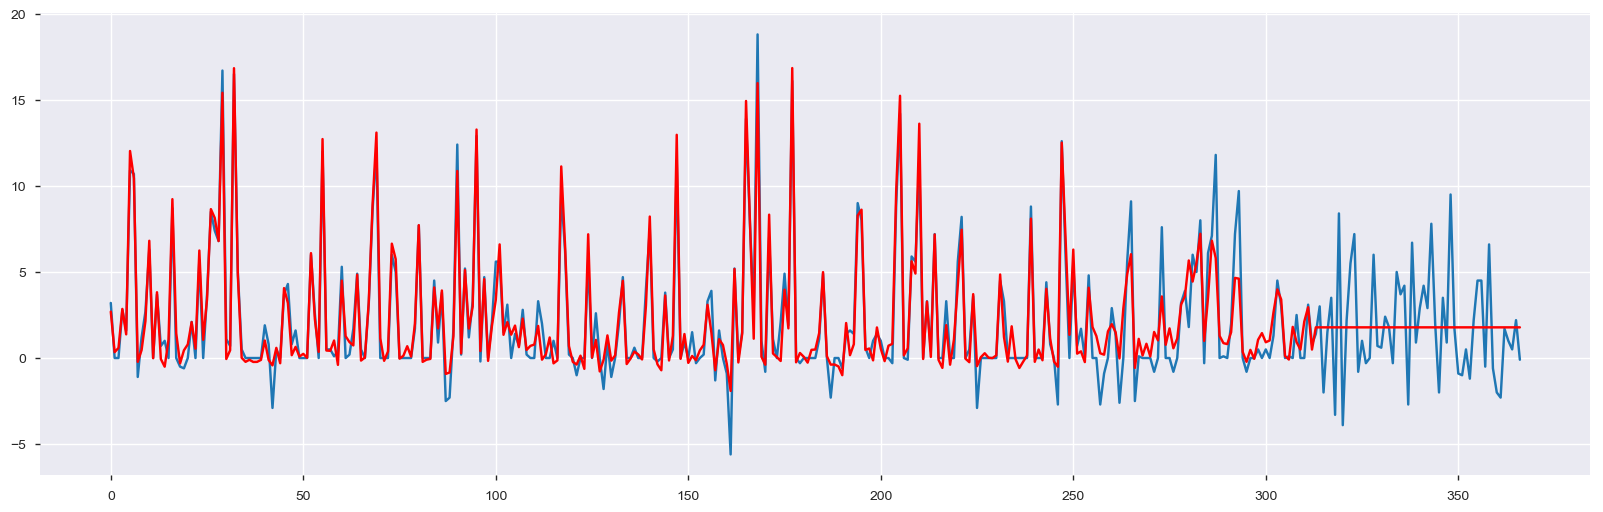

In [13]:
y_pred = model.predict(x)

plt.figure(figsize=(20, 6))
plt.plot(y)
plt.plot(y_pred, color='red')

# Predição de Jogadores

In [14]:
x_test, ids = create_samples(df_samples, cols_of_interest, from_round=2, to_round=3, last_rounds=2, return_pred=False)

print(x_test.shape, ids.shape)

x: rodadas de 2-3 y: rodada 4
(367, 2, 46) (367,)


In [15]:
y_next = model.predict(x_test)
sort_pos = np.argsort(y_next.flatten())
best_ids = ids[sort_pos[-10:]]

print(best_ids)

[ 68698  86686  86757  37688  69141  84848  94583 100651  89493  80287]


In [16]:
assert(np.all(df_samples[COL_ID].values == df_clean[COL_ID].values))

df_pred = df_clean[df_clean[COL_ID].isin(best_ids)].drop_duplicates(subset=COL_ID)
df_pred

,atletas.rodada_id,atletas.atleta_id,atletas.apelido,atletas.posicao_id,atletas.clube.id.full.name,atletas.status_id,atletas.pontos_num,atletas.preco_num,atletas.variacao_num,atletas.media_num,CA,CV,DD,DP,FC,GC,GS,RB,SG,A,FD,FF,FS,FT,G,I,PE,PP
12,1,86757,Everton,ata,Grêmio,Provável,10.6,16.37,3.37,10.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0
163,1,37688,Cícero,mei,Botafogo,Provável,1.6,7.35,-1.65,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0
171,1,84848,Erik,ata,Botafogo,Provável,0.3,7.84,-3.16,0.3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0
323,1,69141,Ricardo Bueno,ata,Ceará,Provável,22.7,18.52,14.52,22.7,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0
467,1,68698,Bruno Silva,mei,Fluminense,Provável,2.7,6.73,-0.27,2.7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,2.0,0.0
507,1,80287,Luciano,ata,Fluminense,Provável,-5.3,3.26,-6.74,-5.3,1.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,2.0,1.0
558,1,94583,Pedro,ata,Fluminense,Provável,0.7,8.81,-3.19,0.7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
707,1,86686,Tchê Tchê,mei,São Paulo,Provável,0.1,3.54,-1.46,0.1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0
89,2,100651,Rodrygo,ata,Santos,Dúvida,7.7,10.58,0.58,7.7,1.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0
269,2,89493,Igor Rabello,zag,Atlético-MG,Provável,3.2,10.07,-1.93,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
